%pip install torchtext
%pip install wandb

In [ ]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import wandb
wandb.login()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


In [ ]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:3000]
data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style','URL':'description'})
data = data[['image','description']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'description']


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 3000/3000 [00:36<00:00, 81.23it/s]


In [ ]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4744, 0.4149, 0.3598])
Std of the image: tensor([0.1894, 0.1900, 0.1915])


In [ ]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(data['image'],data['description'], test_size=0.2, random_state=42)
del data

In [ ]:
#Image Transformations
img_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

img_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

In [ ]:
class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None):
        self.data = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        else:
            tr1 = transforms.ToTensor()
            img_pil = tr1(img_pil)
        return(img_pil,self.labels[index])

train_dataset = ArtDataset(X_train.values,y_train.values,transform=img_train_transform)
val_dataset = ArtDataset(X_val.values,y_val.values,transform=img_test_transform)
del X_train,X_val,y_train,y_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: 16


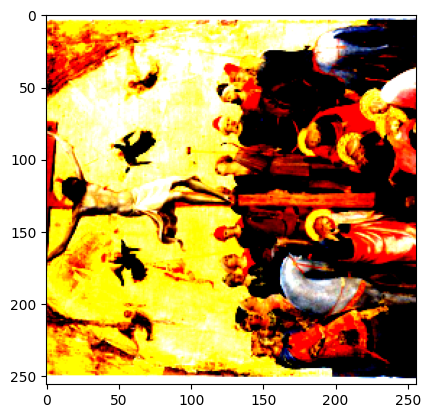

Label: A 1692 Chigi inventory lists two paintings, the Rural Scene and the Figures in a Tree-lined Avenue (see at Cerquozzi) and indicates that they are the product of a collaboration between Angeluccio, who painted the landscape, and Michelangelo Cerquozzi, who painted the figures.These pictures and the documentary reference to them are an important basis for the reconstruction of the career of Giovanni Angelo, known by his nickname "Angeluccio".The biographer Pascoli mentions Angeluccio as a student of Claude GellÃ©e (also known as Claude Lorrain), saying that among Claude's disciples there was "of renown only Angeluccio, who died young and was only able to work a little". Perhaps of Flemish origin (he is cited as a Fleming in an eighteenth century inventory of the Valenti Gonzaga collection), he shows the influence of the Flemish landscape technique, with particular closeness to the work of Bril. His typical compositional characteristics are the rendering of a spatial depth, the sho

In [ ]:
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Label: {label}")

In [ ]:
#Encoder

class EncoderCNN(nn.Module):
    def __init__(self, embed_size = 1024):
        super(EncoderCNN,self).__init__()

        self.net = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        self.net = nn.Sequential(*list(self.net.children())[:-1])
        self.dim = 512

    def forward(self,x):
        x = self.net(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0),-1,x.size(-1))
        return x

In [ ]:
#Attention

class Attention(nn.Module):

    def __init__(self,encoder_dim):
        super(Attention,self).__init__()
        self.U = nn.Linear(256,256)
        self.W = nn.Linear(encoder_dim,256)
        self.V = nn.Linear(256,1)
        self.tahn = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, img_features, hidden_state):
        U_h = self.U(hidden_state).unsqueeze(1)
        W_s = self.W(img_features)
        att = self.tahn(W_s + U_h)
        e = self.V(att).squeeze(2)
        alpha = self.softmax(e)
        context = (img_features * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

In [ ]:
#Decoder

class Decoder(nn.Module):

    def __init__(self,vocab_size,encoder_dim, teacher_forcing=False):
        super(Decoder, self).__init__()
        self.tf = teacher_forcing

        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim

        self.init_h = nn.Linear(encoder_dim,256)
        self.init_c = nn.Linear(encoder_dim,256)
        self.tahn = nn.Tanh()

        self.f_beta = nn.Linear(256,encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.deep_output = nn.Linear(256,vocab_size)
        self.dropout = nn.Dropout(0.5)

        self.attention = Attention(encoder_dim)
        self.embedding = nn.Embedding(vocab_size,256)
        self.lstm = nn.LSTMCell(256+encoder_dim,256)

    def get_init_lstm_state(self,img_features):
        avg_features = img_features.mean(dim=1)

        c = self.init_c(avg_features)
        c = self.tahn(c)

        h = self.init_h(avg_features)
        h = self.tahn(h)

        return h,c

    def forward(self,img_features,captions):
        batch_size = 16

        h,c = self.get_init_lstm_state(img_features)
        max_timespan = max([len(caption) for caption in captions])-1

        prev_words = torch.zeros(batch_size).long().to(device)
        if self.tf:
            embeddings = self.embedding(captions) if self.training else self.embedding(prev_words)
        else:
            embeddings = self.embedding(prev_words)

        preds = torch.zeros(batch_size, max_timespan, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, max_timespan, img_features.size(1)).to(device)
        for t in range(max_timespan):
            context,alpha = self.attention(img_features,h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            if self.tf and self.training:
                lstm_in = torch.cat((embeddings[:,t], gated_context), dim=1)    
            else:
                embeddings = embeddings.squeeze(1) if embeddings.dim()==3 else embeddings
                lstm_in = torch.cat((embeddings, gated_context), dim=1)

            h,c = self.lstm(lstm_in,(h,c))
            output = self.deep_output(self.dropout(h))

            preds[:,t] = output
            alphas[:,t] = alpha

            if not self.training or not self.tf:
                embeddings = self.embedding(output.max(1)[1].reshape(batch_size,1))
        return preds, alphas
    
    #Beam Search
    def captions(self,img_features, beam_size):
        prev_words = torch.zeros(beam_size,1).long()

        sentences = prev_words
        top_preds = torch.zeros(beam_size,1)
        alphas = torch.ones(beam_size,1,img_features.size(1))

        completed_sentences = []
        completed_sentences_scores = []
        completed_sentences_alphas = []

        step = 1
        h,c = self.get_init_lstm_state(img_features)

        while True:
            embedding = self.embedding(prev_words).squeeze(1)
            context,alpha = self.attention(img_features,h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat((embedding,gated_context),dim=1)
            h,c = self.lstm(lstm_input,(h,c))
            output = self.deep_output(h)
            output = top_preds.expand_as(output) + output

            if step == 1:
                top_preds, top_words = output[0].topk(beam_size,0,True,True)
            else:
                top_preds, top_words = output.view(-1).topk(beam_size,0,True,True)
            prev_words_idx = top_words / output.size(1)
            next_words_idx = top_words % output.size(1)

            sentences = torch.cat((sentences[prev_words_idx],next_words_idx.unsqueeze(1)),dim=1)
            alphas = torch.cat((alphas[prev_words_idx],alpha[prev_words_idx].unsqueeze(1)),dim=1)

            incomplete_sentences_idx = [idx for idx, next_word in enumerate(next_words_idx) if next_word != 1]
            complete_sentences_idx = list(set(range(len(next_words_idx))) - set(incomplete_sentences_idx))

            if len(complete_sentences_idx)>0:
                completed_sentences.extend(sentences[complete_sentences_idx].tolist())
                completed_sentences_scores.extend(top_preds[complete_sentences_idx])
                completed_sentences_alphas.extend(alphas[complete_sentences_idx])
                print(complete_sentences_idx)
            beam_size -= len(complete_sentences_idx)

            if beam_size == 0:
                break

            sentences = sentences[incomplete_sentences_idx]
            alphas = alphas[incomplete_sentences_idx]
            h = h[prev_words_idx[incomplete_sentences_idx]]
            c = c[prev_words_idx[incomplete_sentences_idx]]
            img_features = img_features[prev_words_idx[incomplete_sentences_idx]]
            top_preds = top_preds[incomplete_sentences_idx].unsqueeze(1)
            prev_words = next_words_idx[incomplete_sentences_idx].unsqueeze(1)

            if step>50:
                break
            step += 1

        print(completed_sentences_scores)
        idx = completed_sentences_scores.index(max(completed_sentences_scores))
        sentence = completed_sentences[idx]
        alpha = completed_sentences_alphas[idx]
        return sentence,alpha
        

In [ ]:
from torchtext.vocab import GloVe
vocab = GloVe(name='42B', dim=300)

OSError: /opt/conda/envs/pytorch/lib/python3.10/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE

In [ ]:
#Parameters and Hyperparameters

encoder = EncoderCNN().to(device)
decoder = Decoder(len(vocab),encoder.dim).to(device)
optimizer = optim.Adam(decoder.parameters(),lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
cross_entropy_loss = nn.CrossEntropyLoss().to(device)

In [ ]:
#Define the training function


def train(epoch, encoder, decoder, optimizer, cross_entropy_loss, data_loader, word_dict, alpha_c, log_interval):
    encoder.eval()
    decoder.train()

    for batch_idx, (img,caption) in enumerate(data_loader):
        imgs, captions = img.to(device), caption
        img_features = encoder(imgs)
        optimizer.zero_grad()
        preds, alphas = decoder(img_features,captions)
        targets = captions[:,1:]

        targets = nn.utils.rnn.pack_padded_sequence(targets, [len(tar)-1 for tar in targets], batch_first=True)[0]
        preds = nn.utils.rnn.pack_padded_sequence(preds, [len(pred)-1 for pred in preds], batch_first=True)[0]

        att_regularization = alpha_c * ((1 - alphas.sum(dim=1))**2).mean()
        
        loss = cross_entropy_loss(preds, targets) + att_regularization
        optimizer.step()
        loss.backward()

        total_caption_length = targets.size(0) + 1
        wandb.log({"loss":loss.item()})
        
    

In [ ]:
run = wandb.init(
    project='Art',
    config={
        "learning_rage": 0.001,
        "epochs": 2,
    }
)
for epoch in range(1,3):
    scheduler.step()
    train(epoch, encoder, decoder, optimizer, cross_entropy_loss,trainloader, vocab, 1, 1000)

In [ ]:
#Define the evaluation function
def evaluate(valloader,encoderdecoder, loss_fn):
    for i, (images,descriptions) in enumerate(valloader):
        images = images.to(device)
        descriptions = descriptions.to(device)
        outputs = encoderdecoder(images,descriptions)
        loss = loss_fn(outputs,descriptions)
        if i % 100 == 0:
            print(f'Batch: {i}, Loss: {loss.item()}')

In [ ]:
#Define the prediction function
def predict(encoderdecoder,image):
    image = image.to(device)
    feature = encoderdecoder.encoder(image).unsqueeze(1)
    sampled_ids = []
    states = None
    for i in range(20):
        hiddens,states = encoderdecoder.decoder.lstm(feature,states)
        outputs = encoderdecoder.decoder.fc(hiddens.squeeze(1))
        predicted = outputs.max(1)[1]
        sampled_ids.append(predicted)
        feature = encoderdecoder.decoder.embed(predicted)
        feature = feature.unsqueeze(1)
    sampled_ids = torch.stack(sampled_ids,1)
    sampled_ids = sampled_ids[0].cpu().numpy()
    return sampled_ids

In [ ]:
#Define the function to convert the predicted ids to words
def convert_to_words(sampled_ids):
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [ ]:
#Define the function to display the image and the predicted caption
def display_image_caption(image,sentence):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(sentence)
    plt.show()

In [ ]:
#Define the function to display the image and the actual caption
def display_image_caption_actual(image,caption):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(caption)
    plt.show()